# Sotavento: Problema de Clasificación
En el siguiente cuaderno se analiza el rendimiento del modelo escogido para producciones altas y bajas de energía
Tras ello, se transforma el problema original de predicción de producción de la energía en un problema de clasificación.

In [1]:
#Importación de librerías
import pandas as pd
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeRegressor


In [2]:
#Importación de datos del modelo final de regresión. 
import pickle
with open ('modelo_final.pkl', 'rb') as file:
    final_model = pickle.load(file)

# 1. Medición de rendimiento del modelo de regresión.
Tal y como nos indica el enunciado, se considera como producción alta aquella mayor que el tercer cuantil, y baja en otro caso. 
Para ello, primero añadimos una columna a nuestro dataset en función del valor de la energía. Esta nos permitirá realizar las mediciones de error y actuará como etiqueta en nuestro problema de clasificación más adelante. 
 

In [3]:
#Importación de dataset
wind_ava=pd.read_csv('wind_ava.csv.gz', compression = "gzip")

wind_ava['datetime']= pd.to_datetime(wind_ava['datetime'])
wind_ava = wind_ava.set_index('datetime')

for c in wind_ava.columns:
    if not c.endswith('.13') and c != 'datetime' and c != 'energy':
        wind_ava = wind_ava.drop(c, axis = 1)
print("El tamaño del dataset es: ", wind_ava.shape)

El tamaño del dataset es:  (4748, 23)


In [4]:
wind_ava.head()

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-02 18:00:00,402.71,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,...,280.473098,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617
2005-01-03 00:00:00,696.80,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,...,278.286616,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469
2005-01-03 06:00:00,1591.15,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,...,277.206490,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748
2005-01-03 12:00:00,1338.62,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,...,280.926600,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478
2005-01-03 18:00:00,562.50,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,...,277.363875,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114


In [5]:
#Inserción de la nueva columna. 
labels= []
q= wind_ava['energy'].quantile(0.75)
print(q)
#Iteramos 1 vez por fila
for i in wind_ava['energy']:
    if i > q:
        labels.append("High")
    else:
        labels.append("Low")
    print(i, labels[-1])


1089.375
402.71 Low
696.8 Low
1591.15 High
1338.62 High
562.5 Low
232.3 Low
329.95 Low
960.51 Low
194.62 Low
358.51 Low
808.8 Low
93.36 Low
155.94 Low
0.01 Low
4.85 Low
218.76 Low
906.21 Low
201.42 Low
641.34 Low
1524.05 High
943.85 Low
791.4 Low
413.33 Low
170.43 Low
216.48 Low
122.58 Low
327.31 Low
1434.55 High
997.24 Low
1011.12 Low
747.11 Low
761.06 Low
1164.17 High
1410.9 High
1399.9 High
707.84 Low
322.78 Low
243.41 Low
62.85 Low
242.45 Low
193.79 Low
897.88 Low
738.87 Low
652.09 Low
191.28 Low
399.54 Low
1473.27 High
1448.47 High
1620.97 High
108.42 Low
436.67 Low
332.56 Low
6.82 Low
159.31 Low
466.69 Low
1397.77 High
1514.19 High
2101.22 High
838.6 Low
727.37 Low
374.25 Low
960.49 Low
373.42 Low
218.45 Low
158.12 Low
134.68 Low
357.05 Low
279.42 Low
839.06 Low
692.55 Low
268.49 Low
288.9 Low
109.88 Low
256.34 Low
1609.87 High
2279.76 High
2320.36 High
1985.0 High
1968.71 High
1489.33 High
934.96 Low
1315.66 High
896.95 Low
786.17 Low
2137.19 High
2352.94 High
907.34 Low
2215.52

304.92 Low
463.48 Low
497.35 Low
475.32 Low
353.08 Low
246.34 Low
141.79 Low
165.96 Low
852.34 Low
1365.26 High
438.95 Low
412.6 Low
2157.22 High
420.05 Low
114.93 Low
276.33 Low
690.43 Low
1345.64 High
1460.52 High
1907.25 High
1675.65 High
1138.2 High
692.38 Low
1210.78 High
540.72 Low
225.32 Low
145.21 Low
227.37 Low
103.79 Low
520.13 Low
842.0 Low
2095.17 High
1092.13 High
1217.61 High
925.51 Low
1530.29 High
1029.25 Low
532.11 Low
1966.24 High
1754.17 High
1328.95 High
1796.72 High
2130.13 High
2157.89 High
950.16 Low
1111.72 High
378.58 Low
654.07 Low
577.24 Low
1086.23 Low
2421.48 High
1981.98 High
1770.34 High
1787.72 High
911.01 Low
121.3 Low
3.7 Low
781.34 Low
516.99 Low
1934.75 High
810.67 Low
1275.99 High
532.05 Low
2370.51 High
2465.05 High
1992.07 High
2345.69 High
1919.81 High
2513.07 High
1942.0 High
1221.32 High
698.05 Low
334.15 Low
739.8 Low
216.82 Low
611.81 Low
18.94 Low
22.75 Low
238.26 Low
439.73 Low
879.51 Low
1709.4 High
763.96 Low
597.43 Low
847.03 Low
385.38 

1070.39 Low
1036.35 Low
516.54 Low
517.94 Low
42.15 Low
190.93 Low
164.36 Low
572.13 Low
487.16 Low
285.39 Low
293.83 Low
400.01 Low
335.66 Low
386.85 Low
728.44 Low
565.6 Low
278.39 Low
628.38 Low
267.21 Low
19.43 Low
194.96 Low
99.76 Low
561.75 Low
172.56 Low
32.84 Low
417.8 Low
5.22 Low
10.28 Low
335.61 Low
510.93 Low
828.07 Low
1006.46 Low
1334.7 High
530.03 Low
547.06 Low
754.84 Low
488.14 Low
1182.79 High
585.87 Low
1177.28 High
1278.85 High
2116.97 High
1879.78 High
1655.34 High
1714.96 High
1771.47 High
2171.74 High
1396.55 High
674.27 Low
1001.36 Low
759.09 Low
1918.04 High
1489.68 High
1229.17 High
377.15 Low
1398.97 High
1892.19 High
1337.45 High
1371.66 High
1755.62 High
2016.01 High
2113.55 High
2370.73 High
880.14 Low
658.42 Low
971.26 Low
505.54 Low
675.21 Low
1477.87 High
942.36 Low
314.8 Low
716.72 Low
791.13 Low
909.92 Low
0.15 Low
36.36 Low
0.73 Low
8.48 Low
6.23 Low
86.25 Low
109.93 Low
1.1 Low
118.09 Low
241.4 Low
64.7 Low
63.65 Low
87.8 Low
100.98 Low
71.56 Low
9.

221.23 Low
190.22 Low
3.99 Low
132.81 Low
203.59 Low
459.67 Low
1714.44 High
2035.81 High
2081.24 High
593.34 Low
206.6 Low
27.27 Low
0.02 Low
12.04 Low
0.03 Low
376.82 Low
187.23 Low
0.7 Low
682.5 Low
75.67 Low
88.51 Low
1016.65 Low
535.1 Low
548.54 Low
3.64 Low
813.51 Low
1122.78 High
1326.52 High
1897.56 High
265.52 Low
382.7 Low
783.72 Low
1090.43 High
164.68 Low
797.97 Low
958.89 Low
1384.07 High
2031.46 High
2186.58 High
1349.0 High
1575.65 High
1707.89 High
1899.34 High
1934.58 High
1790.86 High
1718.6 High
1462.94 High
578.61 Low
0.39 Low
678.34 Low
868.42 Low
387.41 Low
81.02 Low
207.72 Low
99.33 Low
1.13 Low
8.17 Low
669.29 Low
2.2 Low
269.32 Low
358.54 Low
101.93 Low
592.39 Low
256.45 Low
143.11 Low
81.61 Low
77.74 Low
75.66 Low
6.32 Low
393.36 Low
226.39 Low
152.06 Low
98.8 Low
416.03 Low
278.11 Low
323.79 Low
174.17 Low
1033.69 Low
1251.96 High
1256.85 High
587.52 Low
124.6 Low
26.26 Low
12.99 Low
313.68 Low
349.83 Low
29.03 Low
417.88 Low
226.53 Low
0.05 Low
35.39 Low
356

In [6]:
#Añadimos la nueva columna al dataset
wind_ava['label']= labels
wind_ava.head()

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13,label
datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-02 18:00:00,402.71,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,...,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617,Low
2005-01-03 00:00:00,696.80,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,...,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469,Low
2005-01-03 06:00:00,1591.15,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,...,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748,High
2005-01-03 12:00:00,1338.62,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,...,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478,High
2005-01-03 18:00:00,562.50,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,...,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114,Low


In [7]:
#Crear los nuevos conjuntos para cada segmento: valores altos y bajos.
train= wind_ava[wind_ava.index.map(lambda x: x.year) < 2009]
test= wind_ava[wind_ava.index.map(lambda x: x.year) > 2008]
#A) Datos Low
low_train = train[train['label']=="Low"]
X_low_train = low_train.drop(columns= ['energy', 'label'])
y_low_train= low_train['energy']

low_test = test[test['label']=="Low"]
X_low_test = low_test.drop(columns= ['energy', 'label'])
y_low_test= low_test['energy']

#B) Datos High
high_train = train[train['label']=="High"]
X_high_train = high_train.drop(columns= ['energy', 'label'])
y_high_train = high_train['energy']

high_test = test[test['label']=="High"]
X_high_test = high_test.drop(columns= ['energy', 'label'])
y_high_test = high_test['energy']



## Breve descripción de los conjuntos
Mediante la impresión de gráficos, se comprueba que para ambos casos es factible aplicar un split para el año 2009, en el que de nuevo se aprecia una fal de registros.

In [8]:
low= wind_ava[wind_ava['label']=="Low"]
low_description = low.describe()
low_description

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
count,3561.000000,3.561000e+03,3561.000000,3561.000000,3.561000e+03,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,...,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000
mean,362.086782,2.494573e+06,15.925808,33.385118,1.371739e+06,2.855109,2.588105,-0.036778,-0.364602,97886.145298,...,286.096770,287.172182,287.050810,0.009625,-0.019008,286.780768,0.412789,-5.916011,-0.206247,-0.396672
std,314.398575,4.455299e+04,6.543449,136.465846,1.138635e+06,0.397889,0.116631,2.449708,2.511144,656.705211,...,6.528594,5.764671,4.694613,0.232905,0.258948,3.568073,0.007001,0.086451,3.855077,3.931362
min,0.010000,2.360347e+06,1.650268,0.000000,5.610341e+04,2.323973,2.425866,-6.050706,-8.174159,94448.853443,...,268.970603,275.461648,278.389271,-0.766021,-1.280752,280.875389,0.364805,-6.126757,-8.679070,-11.423468
25%,93.360000,2.463545e+06,11.028465,0.000000,5.785920e+05,2.452018,2.469697,-1.754552,-2.131061,97544.735285,...,281.387096,282.427745,282.812520,-0.109939,-0.148598,283.442785,0.410024,-5.975438,-3.569665,-3.312572
50%,274.670000,2.497911e+06,15.447911,0.568386,1.042191e+06,2.867326,2.588106,-0.281099,-0.417674,97906.621256,...,285.906953,287.306757,286.752011,-0.007796,-0.017299,286.856126,0.410610,-5.949619,-0.491048,-0.917769
75%,597.860000,2.529530e+06,20.098391,11.860313,1.826729e+06,3.231374,2.697598,1.695826,1.137170,98265.716659,...,290.706606,292.090270,291.374406,0.127321,0.076389,290.166308,0.414225,-5.887251,3.042692,2.311722
max,1089.350000,2.579163e+06,39.230807,2311.662152,1.110694e+07,3.450745,2.762992,12.318661,8.807082,99917.733093,...,305.000640,299.556292,295.639998,2.542981,1.411931,292.808658,0.428907,-5.618172,18.052846,12.394340


<AxesSubplot:xlabel='datetime'>

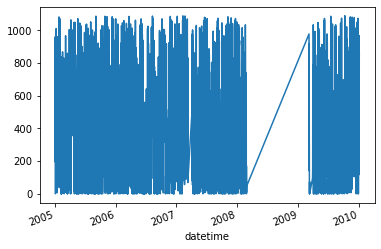

In [9]:
low['energy'].plot(rot=20)

In [10]:
high= wind_ava[wind_ava['label']=="High"]
high_description = high.describe()
high_description

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
count,1187.000000,1.187000e+03,1187.000000,1187.000000,1.187000e+03,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,...,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000
mean,1686.244642,2.474189e+06,16.257815,24.510811,2.711552e+06,2.695558,2.540821,1.655194,1.575917,97622.769252,...,284.466701,285.138809,285.511523,0.268043,0.256908,286.330305,0.416343,-5.885836,2.407439,2.502834
std,399.986593,4.210019e+04,6.574923,58.130835,1.836881e+06,0.371095,0.108407,4.279784,3.830374,831.936638,...,4.702782,4.510301,4.016026,0.571125,0.562628,3.486595,0.008642,0.111893,6.640101,5.873306
min,1089.450000,2.358748e+06,2.404345,0.000000,1.332506e+05,2.323973,2.425866,-8.619823,-8.867441,93770.364813,...,270.547365,275.669274,278.419696,-1.714897,-1.438829,280.878094,0.368735,-6.130465,-11.879053,-13.043453
25%,1347.890000,2.445354e+06,11.689044,0.075785,1.270500e+06,2.383445,2.451240,-2.763346,-1.761125,97133.760681,...,281.554390,281.908487,282.506057,-0.231172,-0.146928,283.370051,0.410170,-5.987316,-5.353798,-3.008731
50%,1635.640000,2.471696e+06,15.803608,3.372421,2.395041e+06,2.529640,2.497573,2.987038,1.942058,97686.546892,...,284.573846,284.389557,284.820021,0.359210,0.207688,285.830520,0.413742,-5.929131,5.056217,3.381400
75%,1990.860000,2.502420e+06,20.698333,22.811209,3.749591e+06,3.057471,2.644344,5.148423,4.716925,98168.173612,...,287.351104,288.068245,288.437974,0.668574,0.609045,289.732130,0.424322,-5.768727,7.847375,7.351534
max,2792.550000,2.580387e+06,36.186044,966.255530,1.108063e+07,3.449699,2.762735,12.974802,11.699814,99764.378681,...,299.200137,297.052410,294.515378,2.842552,2.366522,292.808079,0.428914,-5.642137,18.964137,16.913033


<AxesSubplot:xlabel='datetime'>

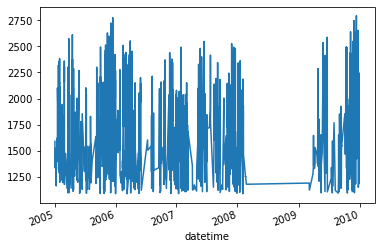

In [11]:
high['energy'].plot(rot=20)

Una vez obtenidos los dos nuevos datasets,se empela el modelo de regresión obtenido (en este caso, un Árbol de Regresión)para evaluar el error en ambos casos y comprobar la variación que experimenta el MSE en función del nivel energético.

In [12]:
#final_model= DecisionTreeRegressor(max_depth= 5, min_samples_split=30)
#1) Energía baja - datos con etiqueta "Low"
final_model.fit(X_low_train, y_low_train)
y_low_pred = final_model.predict(X_low_test)
mse_low = metrics.mean_squared_error(y_low_test, y_low_pred)
r2_low = metrics.r2_score(y_low_test, y_low_pred)
print("Low Energy meassurement results...")
print("Mean Squared Error on Test Set:", mse_low)
print("R2 of final model:", r2_low)

Low Energy meassurement results...
Mean Squared Error on Test Set: 68004.6005623183
R2 of final model: 0.3352865012688546


In [13]:
#Energía alta -datos con etiqueta "High"
final_model.fit(X_high_train, y_high_train)
y_high_pred = final_model.predict(X_high_test)
mse_high = metrics.mean_squared_error(y_high_test, y_high_pred)
r2_high = metrics.r2_score(y_high_test, y_high_pred)
print("High Energy results...")
print("Mean Squared Error on Test Set:", mse_high)
print("R2 of final model:", r2_high)


High Energy results...
Mean Squared Error on Test Set: 148261.26586596787
R2 of final model: 0.2383411798861832


## Conclusiones
Los resultados de los bloques anteriores muestran notables diferencias de rendimiento para ambos conjuntos de datos. 
Para los casos de producción de energía baja (etiquetada como "low" en el dataset), el MSE, medida de referencia para este proyecto, es significativamente menor que en el caso de producciones altas de energía (etiquetadas como "high" en el dataset.
Una posible explicación para estos resultados es la distribución de los datos de trabajo. Al establecer el tercer cuantil del dataset como umbral de clasificación, las instancias de la clase de energía alta (1.187) son muy inferiores a las etiquetadas como energía baja (3.561). De esta forma, el modelo se entrena con menos datos en el segundo caso, empeorando su MSE respecto al primero.  

# 2. Problema de clasificación

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score

clasif = {'Dummy': DummyClassifier(strategy = 'most_frequent', random_state = 55),
          'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state = 55),
          'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('log_reg', LogisticRegression(class_weight = 'balanced', random_state = 55))])
         }

X_train = train.drop(columns = 'label')
y_train = train['label']

X_test = test.drop(columns = 'label')
y_test = test['label']

for model, clf in clasif.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label = 'Low')
    tnr = recall_score(y_test, y_pred, pos_label = 'Low')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    print(f"{model} Classifier:")
    print(f"Accuracy: {accuracy: .4f}")
    print(f"Recall/TPR: {recall: .4f}")
    print(f"TNR: {tnr: .4f}")
    print(f"Balanced Accuracy: {balanced_acc: .4f}")
        

Dummy Classifier:
Accuracy:  0.7600
Recall/TPR:  1.0000
TNR:  1.0000
Balanced Accuracy:  0.5000
KNN Classifier:
Accuracy:  0.7557
Recall/TPR:  0.8629
TNR:  0.8629
Balanced Accuracy:  0.6396
Decision Tree Classifier:
Accuracy:  0.9989
Recall/TPR:  0.9986
TNR:  0.9986
Balanced Accuracy:  0.9993
Logistic Regression Classifier:
Accuracy:  0.9881
Recall/TPR:  0.9843
TNR:  0.9843
Balanced Accuracy:  0.9921
